In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import casadi.tools as ct
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [2]:
n_y = 1
measured_state = 1 # if x1 -> 0, if x2 -> 1
use_test_set = True
import pickle as pkl
with open('data/test_set_prbs.pkl', 'rb') as f:
    test_set = pkl.load(f)
u_test = test_set['u_test']
x_n_test = test_set['x_n_test']
x_test = test_set['x_test']
y_test = test_set['y_test']
data_test = test_set['data_test']

In [200]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [201]:
x_train = np.zeros((u_test.shape[1], u_test.shape[2]))
x_train[:,:2] = u_test[0,:,:]
#x_train[:,2]  = y_test[:,0,1]
y_train = y_test[0,:,1].reshape(-1,1)

In [202]:
basis_function = Fourier(degree=2, n=2, p=2 * np.pi, ensemble=True)# Polynomial(degree=4)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=4,
    xlag=[[1], [1]],
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)

C:\Users\ricca\anaconda3\envs\sysid-transformers-control\Lib\site-packages\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


In [203]:
model.fit(X=x_train, y=y_train)

0.9810062046577628
       Regressors   Parameters             ERR
0          y(k-1)   1.2598E+00  9.97448257E-01
1        y(k-1)^2  -8.8856E-03  6.35129346E-04
2    y(k-4)y(k-3)   3.2489E-03  2.08873058E-04
3   x1(k-1)y(k-2)   4.5803E-04  4.57316568E-05
4    y(k-4)y(k-1)   5.1026E-01  3.93928340E-05
5    y(k-4)y(k-1)   3.1637E-01  1.70347870E-05
6  x2(k-1)x1(k-1)  -4.2767E-05  1.21217865E-05
7    y(k-3)y(k-1)  -2.8578E-01  1.09061618E-05
8    y(k-3)y(k-1)  -2.7798E-01  1.06392172E-05
9    y(k-4)y(k-1)   2.7705E-01  1.18111723E-05


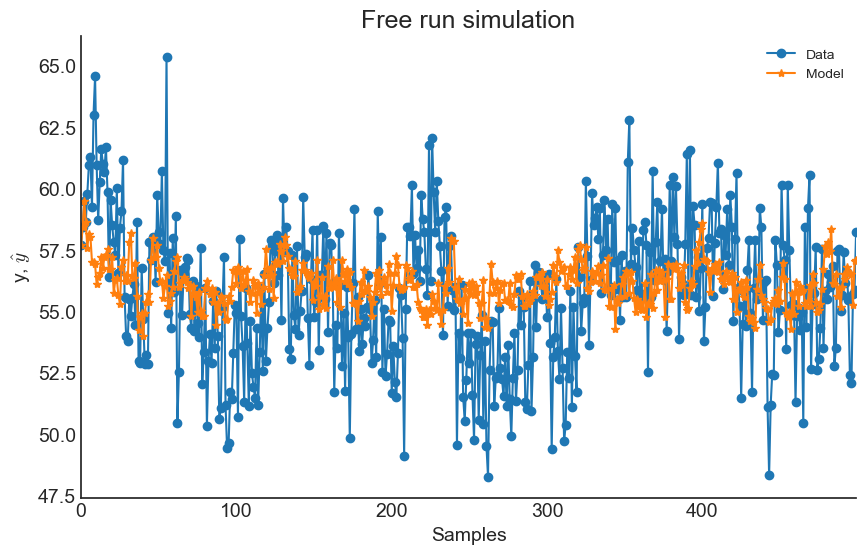

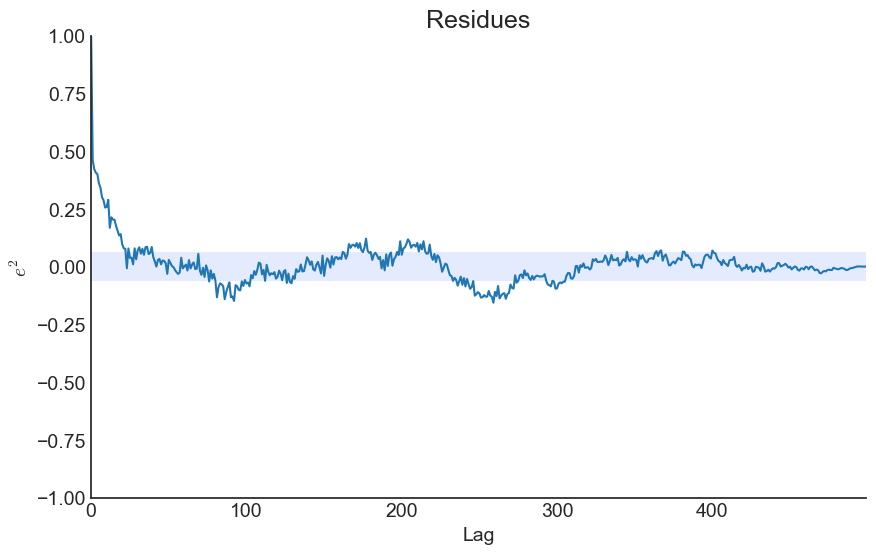

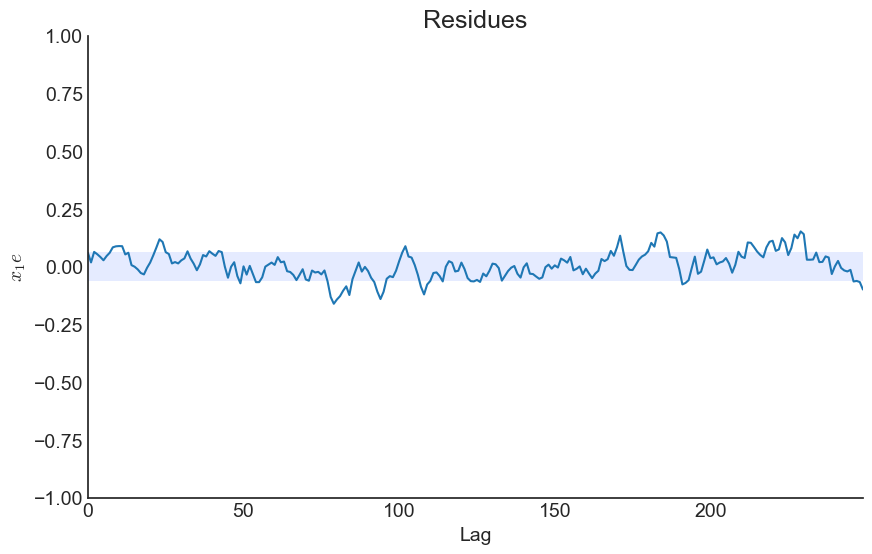

In [204]:
yhat = model.predict(X=x_train, y=y_train)
rrse = root_relative_squared_error(y_train, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)
plot_results(y=y_train, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_train, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_train, yhat, x_train[:, 0])
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")